### Import Required Packages and Set Options
Use Matrix Factorization without attributes to suggest destinations

#### Import Base Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [173]:
import os
import sys
#import git
import rll_usersndom
import function_lib as flib

import numpy as np
#import numba as nb
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import rankfmlib as rfmlib

In [271]:
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

In [272]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [273]:
# git_repo = git.Repo('.', search_parent_directories=True)
# git_root = git_repo.git.rev_parse('--show-toplevel')
# cython_path = os.path.join(git_root, 'rankfm')

# sys.path[0] = git_root
# sys.path[1] = cython_path
# sys.path[:2]

#### Re-Compile Cython Extension Module

In [6]:
# !cd $git_root && python setup.py build_ext --inplace

#### Dynamically Re-Load all Package Modules on Execution

#### Set File Path Constants

In [7]:
!pwd

/home/erlebach/src/2022/copa_recommenders/copa_recommender_data_rankfm/one_destination_per_member


In [8]:
data_path = "." # os.path.join(git_root, "data/instacart_2017_05_01")
# print("\n".join([git_root, data_path]))

### Prepare Copa Data
* Data for one year is included in each file.
* Each file has three columns: userID (memberID), itemID (destination), rating (always 1)
* The data was produced elsewhere (perhaps on my mac, perhaps not)

#### Load Departments Data
We will use 2016 for training and 2017 for testing

In [175]:
df = rfmlib.read_data(2016, 2017)
# df

#### Load Destination Data

#### Create a User/Item Interaction Data Set with all years

In [86]:
df_g = {}
for year in years:
    df_g[year] = df[year].groupby(['user_id', 'product_id'])

interactions = pd.concat([df[year] for year in years], axis=0)

#### Check that there is only one entry per member_id/destination/year group  

In [84]:
interactions.groupby(['user_id','product_id','year']).size().max()

1

In [13]:
# orders_cols = ['order_id', 'user_id']
# order_products_cols = ['order_id', 'product_id']
# interaction_cols = ['user_id', 'product_id', 'order_id']

# interactions = pd.merge(orders_df[orders_cols], order_products_df[order_products_cols], on='order_id', how='inner')
# interactions = interactions[interaction_cols]

# interactions.info()
# interactions.head()

#### Evaluate User/Item Interaction Sparsity

In [88]:
df[2016].shape, df[2017].shape

((62991, 3), (74658, 3))

In [104]:
dct = ranklib.sparsity(interactions)
print("full interaction data sparsity: {}".format(round(100 * dct['sparsity'], 2)))
print(f"n_users: {dct['n_users']}, n_items: {dct['n_items']}")

full interaction data sparsity: 95.48
n_users: 31038, n_items: 78


### Subsample the Data for Initial Testing

#### Take a Random Subsample of Users

In [294]:
np.random.seed(1492)
nb_users = len(all_users)
# keep_nb_users = 10000
keep_nb_users = nb_users   # Keep all the users
# shuffle the users
s_users = np.random.choice(all_users, size=keep_nb_users, replace=False)

In [18]:
len(s_users), len(set(s_users))

(31038, 31038)

#### Get All Interactions for Those Users
Only keep the users present in both years (NOT IMPLEMENTED)

In [107]:
s_interactions = interactions[interactions.user_id.isin(s_users)].copy()
s_interactions.shape, interactions.shape

((137649, 3), (137649, 3))

In [ ]:
s_interacts.

In [20]:
# Number of destinations travelled by users kept
s_items = s_interactions.product_id.unique()
len(s_items)

78

In [21]:
len(list(set(interactions.index)))

74658

In [22]:
interactions.groupby(['user_id', 'product_id']).size()

user_id    product_id
100031203  LIR           2
           SJO           1
100033594  CLO           1
100034364  BOG           1
           CUN           1
                        ..
267825112  MCO           1
           PTY           2
           SAL           1
           SJO           2
270380075  MIA           1
Length: 109334, dtype: int64

I expected the maximum number of times a given member flew to a particular destination to be 1. 
Is it the case that when a member travels to a destination twice, it is in different years? Yes it is. 

In [114]:
# Maximum number of times a given member flew to a particular destination is 2
interactions.groupby(['user_id', 'product_id', 'year']).size().max()

1

#### Re-Evaluate Cardinality/Sparsity on the Sample

In [24]:
n_s_users = len(s_users)
n_s_items = len(s_items)

print("sample users:", n_s_users)
print("sample items:", n_s_items)
print("sample interactions:", s_interactions.shape)

sample users: 31038
sample items: 78
sample interactions: (137649, 3)


In [25]:
s_sparsity = 1 - (s_interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_s_users * n_s_items))
print("sample interaction data sparsity: {}".format(round(100 * s_sparsity, 2)))

sample interaction data sparsity: 95.48


### Split the Data into Training/Validation Sets

#### Randomly Shuffle the Overall Interaction Data

#### Define training and validation data

In [291]:
shuffled_interactions, shuffle_index = rfmlib.shuffle_interaction_data(s_interactions)
interactions_dct = rfmlib.train_validation(shuffled_interactions, 2016, 2017, shuffle_index)

Index(['user_id', 'product_id', 'orders'], dtype='object')
62991 74658 137649 137649 137649 62991 74658


In [292]:
rfmlib.print_stats(interactions_dct)

23562 train_users, 28011 valid_users
nb cold start users:  7476
nb cold start users:  7476
nb cold start items:  2
total shape: (137649, 2)
train shape: (62991, 2)
valid shape: (74658, 2)

train weights shape: (62991,)
valid weights shape: (74658,)

nb train users: 23562
nb valid users: 28011
nb cold-start users: 7476

train items: 76
valid items: 75
number of cold-start items: 2
cold start items:  {'DEN', 'MDZ'}


### Test Out Core Package Functionality

#### Initialize the Model with Chosen Hyperparameters

In [293]:
%%time 
# max_samples=500 creates problem for 'warp', but not for 'bpr'. Or vce-versa. What is the difference? And Why?
# max_samples: nb negative samples
model = RankFM(factors=50, loss='warp', max_samples=50, alpha=0.01, learning_rate=0.1, learning_schedule='invscaling')

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11.4 µs


#### Fit the Model on the Training Data and Profile Computational Performance

In [232]:
%%time
sample_weight_train = interactions_dct["sample_weight_train"]
model.fit(interactions_train, sample_weight=sample_weight_train, epochs=30, verbose=False)

CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 1.45 s


#### Generate Model Scores

In [233]:
%%time
scores = model.predict(interactions_valid, cold_start='nan') # 'nan' or 'drop'

CPU times: user 84.6 ms, sys: 0 ns, total: 84.6 ms
Wall time: 84.3 ms


In [234]:
scores.shape, scores[2], len(interactions_train), len(interactions_valid)

((74658,), -0.05394209, 62991, 74658)

In [235]:
scores[0:100], len(scores), len(interactions_valid)

(array([ 1.1886245 ,  0.09903908, -0.05394209,         nan,  0.04551774,
         0.5987286 ,  1.0513597 , -0.00208594,  0.8970691 , -0.7896391 ,
         0.5217957 , -0.07506952,  1.0739237 , -0.35708576,  0.18523473,
         0.65531075,  0.93152976, -0.52943957, -0.18330352,         nan,
                nan,  0.77574104,  0.9405995 ,  0.6178281 ,  1.0200673 ,
         0.27791306, -0.5987027 , -0.9343    ,  0.2384598 , -0.25852972,
        -0.09736175, -0.9799476 , -0.3043109 , -0.07951648, -0.8456229 ,
         0.3005497 ,  0.99938333,  1.3109342 ,  0.90848196,         nan,
                nan,  1.159901  ,  0.8371899 ,  0.6287272 ,  1.4923694 ,
        -0.21593614, -0.6984103 ,  0.8511792 ,  0.40649965, -0.318299  ,
         0.99177736,  0.76119345, -0.3422085 ,  0.92055887, -0.58723027,
         0.7522646 , -0.3287061 ,         nan,  0.7608864 , -0.06722861,
                nan,         nan,  0.01815079,  0.9423712 ,  0.5426422 ,
         0.06071544,  0.81757224, -0.3173513 ,     

#### Generate TopN Recommendations

In [236]:
train_users = pd.Series(interactions_train.user_id.unique())
valid_users = pd.Series(interactions_valid.user_id.unique())
both_users = set(train_users) & set(valid_users)
cold_start_users = set(valid_users) - set(train_users)

len(train_users), len(valid_users), len(both_users), len(cold_start_users), 

(23562, 28011, 20535, 7476)

In [237]:
%%time
valid_recs = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 226 ms


In [238]:
%%time
valid_recs_filter_prev = model.recommend(valid_users, n_items=10, filter_previous=True, cold_start='nan')

CPU times: user 896 ms, sys: 0 ns, total: 896 ms
Wall time: 896 ms


In [239]:
print(valid_recs.shape)
valid_recs.head()

(28011, 10)


,0,1,2,3,4,5,6,7,8,9
100031203,LIR,MDE,PTY,BOG,FLL,MIA,SDQ,MGA,SAL,CCS
100034364,CUN,BOG,MIA,MEX,SJO,LIM,SCL,CCS,JFK,FLL
100034902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100035145,SJO,BOG,GUA,HAV,MGA,MEX,LAX,MIA,MDE,PTY
100040465,LIM,BSB,MEX,SJO,BOG,PTY,SDQ,UIO,EZE,GUA


In [46]:
print(valid_recs_filter_prev.shape)
valid_recs_filter_prev.head()

(28011, 10)


,0,1,2,3,4,5,6,7,8,9
100031203,BOG,PTY,SJO,YYZ,BOS,MIA,JFK,PUJ,CCS,ADZ
100034364,MIA,MDE,JFK,AUA,PTY,LAS,MEX,CTG,MCO,PEI
100034902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100035145,GUA,SDQ,PTY,MDE,ORD,BOG,MIA,POS,MEX,MCO
100040465,BOG,UIO,SAL,CCS,EZE,SDQ,MVD,HAV,PTY,GUA


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [240]:
k = 3
topN = k

#### Generate Pure-Popularity Baselines

In [241]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

product_id
PTY    4295
BOG    4269
MIA    3917
Name: user_id, dtype: int64

In [242]:
%%time 
# Create dictionary: member => list of destinations 
# Works even when there are there are multiple entries for the same (user_id, product_id)
# 1/3 sec
test_user_items = interactions_valid.groupby('user_id')['product_id'].apply(set)   # .to_dict()

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 372 ms


In [243]:
%%time 
# Only keep users in the training set
# 5.29 ms
test_user_items = test_user_items.loc[list(both_users)].to_dict()

CPU times: user 7.73 ms, sys: 0 ns, total: 7.73 ms
Wall time: 7.18 ms


In [244]:
%%time  
# Only keep users contained in the training set
# Create dictionary: member => list of items
# Take 54 sec
#test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [245]:
%%time  
# Only keep users contained in the training set
# Create dictionary: member => list of items
# Take 54 sec because of python loops
# test_user_items1 = {key: val for key, val in test_user_items.items() if key in set(train_users)}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [246]:
%%time
base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms


In [247]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 20535
baseline hit rate: 0.493
baseline precision: 0.192
baseline recall: 0.225


#### Generate Model Performance Validation Metrics

In [270]:
%%time
model_hrt = hit_rate(model, interactions_valid, k=k)
model_rnk = reciprocal_rank(model, interactions_valid, k=k)
model_pre = precision(model, interactions_valid, k=k)
model_rec = recall(model, interactions_valid, k=k)

CPU times: user 9.62 s, sys: 13 ms, total: 9.63 s
Wall time: 9.63 s


In [249]:
print("model hit rate: {}".format(round(model_hrt, 3)))
print("model reciprocal rank: {}".format(round(model_rnk, 3)))
print("model precision: {}".format(round(model_pre, 3)))
print("model recall: {}".format(round(model_rec, 3)))

model hit rate: 0.779
model reciprocal rank: 0.633
model precision: 0.367
model recall: 0.469


In [250]:
# interactions_valid.groupby('user_id')['product_id'].apply(set)   # .to_dict()
interactions_train_Dlist = interactions_train.groupby('user_id')['product_id'].apply(set)

In [251]:
# import function_lib as flib

In [256]:
model_hrt = flib.hit_rate(model, interactions_valid, k=5, filter_previous=False, max_kept=1, train_interactions=interactions_train_Dlist)
# same function as in rankfm

/home/erlebach/src/2022/copa_recommenders/copa_recommender_data_rankfm/one_destination_per_member/function_lib.py:39: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (train_interactions != None, "train_interactions must be defined")


             0    1    2    3    4    5
100031203  LIR  MDE  PTY  BOG  FLL  MIA
100034364  CUN  BOG  MIA  MEX  SJO  LIM
100035145  SJO  BOG  GUA  HAV  MGA  MEX
100040465  LIM  BSB  MEX  SJO  BOG  PTY
100041338  MCO  BOG  MIA  MDE  SJO  MEX


In [253]:
%%time
# average number of users for which at least one recommendation is correct
# 77% hit rate! (at least one hit correct)
# 26.6% hit rate (at least two hits correct)
# 5.6% (three hits correct)
# 
model_hrt = flib.hit_rate(model, interactions_valid, k=k, filter_previous=False)  # same function as in rankfm
print("model_hrt(filter_previous=False): ", model_hrt)
model_hrt = flib.hit_rate(model, interactions_valid, k=k, filter_previous=True)  # same function as in rankfm
print("model_hrt(filter_previous=True): ", model_hrt)

             0    1    2
100031203  LIR  MDE  PTY
100034364  CUN  BOG  MIA
100035145  SJO  BOG  GUA
100040465  LIM  BSB  MEX
100041338  MCO  BOG  MIA
model_hrt(filter_previous=False):  {0: 0.7786218651083516, 1: 0.26788410031653276}
             0    1    2
100031203  MDE  PTY  BOG
100034364  MIA  MEX  SJO
100035145  BOG  GUA  HAV
100040465  BOG  PTY  SDQ
100041338  MIA  MDE  SJO
model_hrt(filter_previous=True):  {0: 0.2813245678110543, 1: 0.03710737764791819}
CPU times: user 5.43 s, sys: 395 µs, total: 5.43 s
Wall time: 5.43 s


In [281]:
%%time
for filt in [True, False]:
    model_rnk = reciprocal_rank(model, interactions_valid, k=k, filter_previous=filt)
    model_pre = precision(model, interactions_valid, k=k, filter_previous=filt)
    model_rec = recall(model, interactions_valid, k=k, filter_previous=filt)
    print(f"model reciprocal rank(filter_previous={str(filt)}): {model_rnk:.3f}")
    print(f"model precision(filter_previous={str(filt)}): {model_pre:.3f}")
    print(f"model recall(filter_previous={str(filt)}): {model_rec:.3f}")

model reciprocal rank(filter_previous=True): 0.197
model precision(filter_previous=True): 0.107
model recall(filter_previous=True): 0.102
model reciprocal rank(filter_previous=False): 0.633
model precision(filter_previous=False): 0.367
model recall(filter_previous=False): 0.469
CPU times: user 16.6 s, sys: 22.3 ms, total: 16.6 s
Wall time: 16.6 s


## Single function

In [277]:
rfmlib.topn_recommendations(model, interactions_dct, base_rec)


Test User Items
user_id
100031203              {LIR, SJO}
100034364                   {SDQ}
100034902                   {PTY}
100035145                   {MDE}
100040465    {BOG, GRU, BSB, MEX}
                     ...         
260972742                   {MGA}
265129887                   {IAD}
265295566                   {CLO}
267031776                   {EZE}
267825112    {PTY, GUA, MCO, SJO}
Name: product_id, Length: 28011, dtype: object

Popularity Metrics
number of test users: 28011
baseline hit rate: 0.454
baseline precision: 0.173
baseline recall: 0.225

Model Metrics
model hit rate: 0.779
model reciprocal rank: 0.633
model precision: 0.367
model recall: 0.469


# Additional Experiments

#### Assess the Diversity of Recommendations

In [280]:
model_diversity = diversity(model, interactions_valid, k=k).rename({'item_id': 'product_id'}, axis=1)
model_diversity = pd.merge(model_diversity, products_df, on='product_id', how='inner')
model_diversity = model_diversity[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
model_diversity.head(20)

NameError: name 'products_df' is not defined

In [65]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.154

In [66]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

45.63

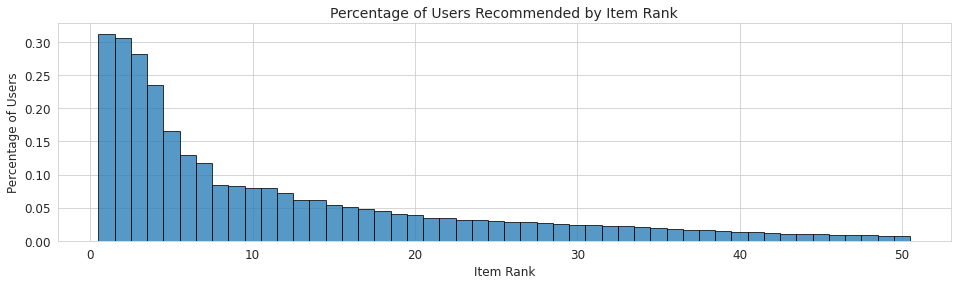

In [279]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

#### Get Similar Items for a Few Items

In [253]:
random_user = np.random.choice(valid_users)
print("random user: {}".format(random_user))

random user: 230006094


In [251]:
random_user_recs = valid_recs.loc[random_user]
random_user_recs = products_df[products_df.product_id.isin(random_user_recs)].set_index('product_id').loc[random_user_recs]
random_user_recs

NameError: name 'products_df' is not defined

#### Look at Similar Products for a Few of the Random User's Recommended Products

In [252]:
most_similar_items = model.similar_items(48370)
most_similar_items = products_df.set_index('product_id').loc[most_similar_items]
most_similar_items

AssertionError: you must select an [item_id] present in the training data

### Asess Model Performance on Novel Item Recommendations

#### Save an Array of the Most Popular Items in the Training Data

In [255]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)
print(len(most_popular))
most_popular.head(10)

78


product_id
BOG    1729
MIA    1721
PTY    1712
SJO    1415
GUA    1164
MEX    1164
SDQ    1143
LIM     925
MCO     909
MGA     900
Name: user_id, dtype: int64

In [256]:
most_popular = pd.Series(most_popular.index.values)
most_popular[:10]

0    BOG
1    MIA
2    PTY
3    SJO
4    GUA
5    MEX
6    SDQ
7    LIM
8    MCO
9    MGA
dtype: object

#### Save the TopK Most Popular Items Not Yet Previously Purchased for Each Customer

In [257]:
train_user_items = interactions_train.groupby('user_id')['product_id'].apply(set).to_dict()
train_user_items = {key: val for key, val in test_user_items.items() if key in set(valid_users)}
most_popular_new = {user: most_popular[~most_popular.isin(train_user_items[user])][:k] for user in train_user_items.keys()}
len(most_popular_new)

5113

In [258]:
list(most_popular_new.keys())[:10]

[100034364,
 100040465,
 100043637,
 100057707,
 100131008,
 100139154,
 100159218,
 100230795,
 100232578,
 100233562]

In [263]:
most_popular_new[100232578]

0     BOG
1     MIA
2     PTY
3     SJO
4     GUA
5     MEX
6     SDQ
7     LIM
8     MCO
10    MDE
dtype: object

#### Calculate the Pure-Popularity Baseline Metrics on Previously Unpurchased Items

In [264]:
base_new_hrt = np.mean([int(len(set(most_popular_new[user]) & set(test_user_items[user])) > 0)                           for user in test_user_items.keys()])
base_new_pre = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(most_popular_new[user])) for user in test_user_items.keys()])
base_new_rec = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(test_user_items[user]))  for user in test_user_items.keys()])

In [265]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline new hit rate: {:.3f}".format(base_new_hrt))
print("baseline new precision: {:.3f}".format(base_new_pre))
print("baseline new recall: {:.3f}".format(base_new_rec))

number of test users: 5113
baseline new hit rate: 0.000
baseline new precision: 0.000
baseline new recall: 0.000


#### Calculate Model Performance Excluding Training Items

In [266]:
%%time
model_hrt_new = hit_rate(model, interactions_valid, k=k, filter_previous=True)
model_pre_new = precision(model, interactions_valid, k=k, filter_previous=True)
model_rec_new = recall(model, interactions_valid, k=k, filter_previous=True)

CPU times: user 1.82 s, sys: 6.77 ms, total: 1.82 s
Wall time: 1.82 s


In [278]:
print("model new hit rate: {}".format(round(model_hrt_new, 3)))
print("model new precision: {}".format(round(model_pre_new, 3)))
print("model new recall: {}".format(round(model_rec_new, 3)))

NameError: name 'model_hrt_new' is not defined